In [2]:
import pandas as pd

df = pd.read_csv('C:/Users/Swaroop/isro project/solar_flux_data.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
train_data = df[df['Date'].dt.year<1996]
test_data = df[df['Date'].dt.year>=1996]

In [5]:
test_data['sfu']

17853    75.000000
17854    74.000000
17855    80.000000
17856    85.000000
17857    84.000000
           ...    
26981    85.983333
26982    84.433333
26983    83.583333
26984    82.733333
26985    82.733333
Name: sfu, Length: 9133, dtype: float64

In [7]:
import numpy as np
sequence = df['sfu']

def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# define input sequence
raw_seq = df['sfu']
# choose a number of time steps
n_steps = 27
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
# for i in range(len(X)):
# 	print(X[i], y[i])

In [217]:
train = np.array(train_data['sfu'])
test = np.array(test_data['sfu'])


In [218]:
train.shape, test.shape

((17853,), (9133,))

In [11]:
train_X.shape

(17826, 27)

In [12]:
train_X.reshape(train_X.shape[0], train_X.shape[1], 1)

array([[[260.        ],
        [244.5       ],
        [229.        ],
        ...,
        [321.33333333],
        [307.        ],
        [286.        ]],

       [[244.5       ],
        [229.        ],
        [213.5       ],
        ...,
        [307.        ],
        [286.        ],
        [265.        ]],

       [[229.        ],
        [213.5       ],
        [198.        ],
        ...,
        [286.        ],
        [265.        ],
        [244.        ]],

       ...,

       [[ 73.        ],
        [ 73.        ],
        [ 72.        ],
        ...,
        [ 74.        ],
        [ 74.        ],
        [ 76.        ]],

       [[ 73.        ],
        [ 72.        ],
        [ 73.        ],
        ...,
        [ 74.        ],
        [ 76.        ],
        [ 76.        ]],

       [[ 72.        ],
        [ 73.        ],
        [ 74.        ],
        ...,
        [ 76.        ],
        [ 76.        ],
        [ 75.        ]]])

In [10]:
train_X, train_y = split_sequence(np.array(train_data['sfu']), 27)
# print("train split done")
test_X, test_y = split_sequence(np.array(test_data['sfu']), 27)

In [ ]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)
# train_y, test_y = scaler.transform(train_y.reshape(-1, 1)), scaler.fit_transform(test_y.reshape(-1, 1))

In [221]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

n_features = 1
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))

# Define model
n_steps = 54
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile model with learning rate of 0.001
# optimizer = SGD(lr = 0.001)
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Define checkpoint callback
checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Fit model with checkpointing
history = model.fit(train_X, train_y, epochs=100, verbose=1, validation_data = (test_X, test_y), callbacks=[checkpoint])

Epoch 1/100
557/557 [==============================] - 14s 22ms/step - loss: 16253.3154 - val_loss: 8041.3462
Epoch 2/100
557/557 [==============================] - 11s 20ms/step - loss: 11579.0723 - val_loss: 5309.4609
Epoch 3/100
557/557 [==============================] - 11s 20ms/step - loss: 8515.5439 - val_loss: 3567.5186
Epoch 4/100
557/557 [==============================] - 11s 20ms/step - loss: 6389.9312 - val_loss: 2522.3845
Epoch 5/100
557/557 [==============================] - 11s 20ms/step - loss: 4864.8794 - val_loss: 1745.8820
Epoch 6/100
557/557 [==============================] - 11s 20ms/step - loss: 3644.0381 - val_loss: 1161.3800
Epoch 7/100
557/557 [==============================] - 11s 20ms/step - loss: 2578.1575 - val_loss: 748.3306
Epoch 8/100
557/557 [==============================] - 11s 20ms/step - loss: 1830.4130 - val_loss: 497.2511
Epoch 9/100
557/557 [==============================] - 11s 20ms/step - loss: 1310.2946 - val_loss: 338.8114
Epoch 10/100
557/557

<AxesSubplot: >

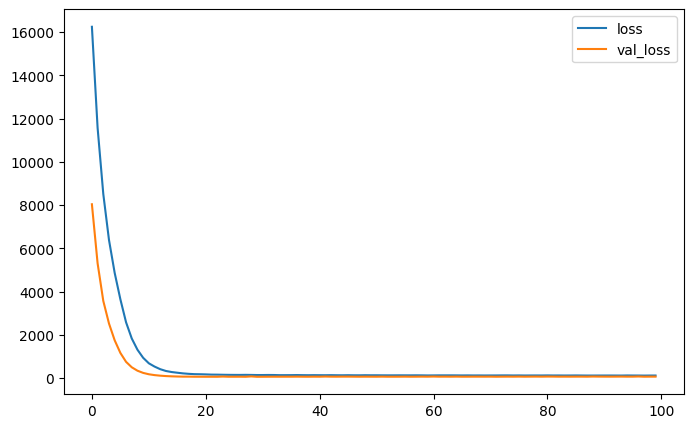

In [223]:
pd.DataFrame(history.history).plot(figsize=(8,5))


In [224]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
pred_y = model.predict(test_X)

284/284 [==============================] - 3s 7ms/step


In [225]:
from sklearn.metrics import r2_score, mean_squared_error

# Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
r2 = r2_score(test_y, pred_y)
rmse = np.sqrt(mean_squared_error(test_y, pred_y))


print("R2 score:", r2)
print("RMSE: ", rmse)

R2 score: 0.9655827532666791
RMSE:  8.047067086158675


In [18]:
model.save('singlelayerLSTM.h5')

LSTM with 64 units

In [35]:
train_X, train_y = split_sequence(train_data['sfu'], 27)
# print("train split done")
test_X, test_y = split_sequence(np.array(test_data['sfu']), 27)

In [43]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

n_features = 1
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))

# Define model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# Compile model with learning rate of 0.001
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Define checkpoint callback
checkpoint = ModelCheckpoint('singleLSTM64.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Fit model with checkpointing
history = model.fit(train_X, train_y, epochs=50, verbose=1, validation_data = (test_X, test_y), callbacks=[checkpoint])

Epoch 1/50


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


558/558 [==============================] - 8s 12ms/step - loss: 4503.5581 - val_loss: 425.3190
Epoch 2/50
558/558 [==============================] - 6s 11ms/step - loss: 435.6338 - val_loss: 252.2152
Epoch 3/50
558/558 [==============================] - 6s 11ms/step - loss: 295.8269 - val_loss: 208.0896
Epoch 4/50
558/558 [==============================] - 6s 11ms/step - loss: 258.1609 - val_loss: 192.5838
Epoch 5/50
558/558 [==============================] - 7s 12ms/step - loss: 227.2689 - val_loss: 176.0780
Epoch 6/50
558/558 [==============================] - 6s 11ms/step - loss: 182.7075 - val_loss: 132.9037
Epoch 7/50
558/558 [==============================] - 6s 11ms/step - loss: 442.1055 - val_loss: 233.8338
Epoch 8/50
558/558 [==============================] - 7s 12ms/step - loss: 258.0867 - val_loss: 215.4211
Epoch 9/50
558/558 [==============================] - 6s 11ms/step - loss: 243.1081 - val_loss: 210.2695
Epoch 10/50
558/558 [==============================] - 6s 10ms/st

<AxesSubplot: >

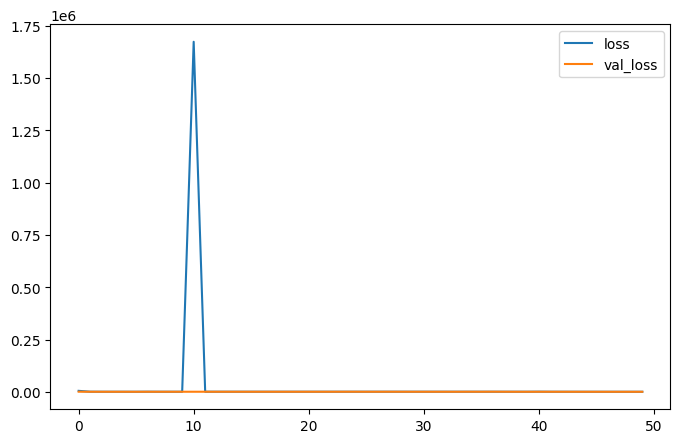

In [50]:
pd.DataFrame(history.history).plot(figsize=(8,5))


In [48]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
pred_y = model.predict(test_X)

285/285 [==============================] - 1s 4ms/step


In [49]:
from sklearn.metrics import r2_score, mean_squared_error

# Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
r2 = r2_score(test_y, pred_y)
rmse = np.sqrt(mean_squared_error(test_y, pred_y))


print("R2 score:", r2)
print("RMSE: ", rmse)

R2 score: 0.9498129583135507
RMSE:  9.713121414944831


2 layer LSTM with 64 32 units

In [51]:
train_X, train_y = split_sequence(train_data['sfu'], 27)
# print("train split done")
test_X, test_y = split_sequence(np.array(test_data['sfu']), 27)

In [53]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

n_features = 1
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))

# Define model
model = Sequential()
model.add(LSTM(64, activation='relu',return_sequences= True,  input_shape=(n_steps, n_features)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))

# Compile model with learning rate of 0.001
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Define checkpoint callback
checkpoint = ModelCheckpoint('2LayerLSTM6432.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Fit model with checkpointing
history = model.fit(train_X, train_y, epochs=50, verbose=1, validation_data = (test_X, test_y), callbacks=[checkpoint])

Epoch 1/50


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


558/558 [==============================] - 14s 21ms/step - loss: 15805.8418 - val_loss: 450.5784
Epoch 2/50
558/558 [==============================] - 12s 21ms/step - loss: 319.1072 - val_loss: 255.3444
Epoch 3/50
558/558 [==============================] - 12s 22ms/step - loss: 196.1938 - val_loss: 262.3435
Epoch 4/50
558/558 [==============================] - 10s 18ms/step - loss: 408.4316 - val_loss: 379.1798
Epoch 5/50
558/558 [==============================] - 10s 19ms/step - loss: 434.1399 - val_loss: 351.2359
Epoch 6/50
558/558 [==============================] - 10s 19ms/step - loss: 337.5121 - val_loss: 262.4095
Epoch 7/50
558/558 [==============================] - 11s 19ms/step - loss: 714.4034 - val_loss: 402.0923
Epoch 8/50
558/558 [==============================] - 12s 21ms/step - loss: 599.0800 - val_loss: 468.7356
Epoch 9/50
558/558 [==============================] - 11s 20ms/step - loss: 586.9237 - val_loss: 396.5370
Epoch 10/50
558/558 [==============================] - 

<AxesSubplot: >

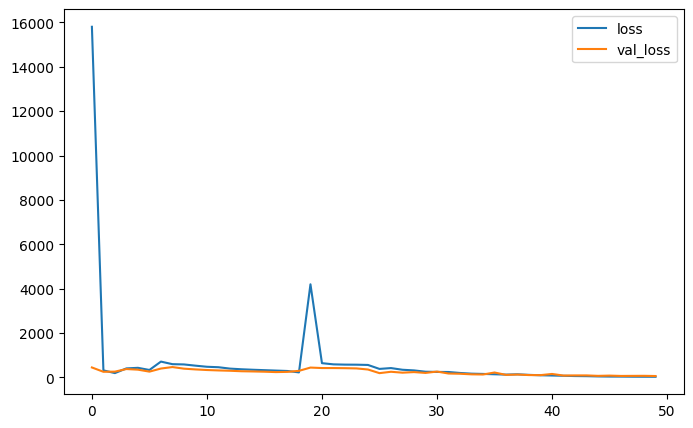

In [54]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [55]:
from sklearn.metrics import r2_score, mean_squared_error

# Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
r2 = r2_score(test_y, pred_y)
rmse = np.sqrt(mean_squared_error(test_y, pred_y))


print("R2 score:", r2)
print("RMSE: ", rmse)

R2 score: 0.9498129583135507
RMSE:  9.713121414944831


2 LAYERED LSTM WITH BOTH RETURN_SEQ = True

In [57]:
train_X, train_y = split_sequence(train_data['sfu'], 27)
# print("train split done")
test_X, test_y = split_sequence(np.array(test_data['sfu']), 27)

In [71]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

n_features = 1
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))

# Define model
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences= True,  input_shape=(n_steps, n_features)))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dense(1))

# Compile model with learning rate of 0.001
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Define checkpoint callback
checkpoint = ModelCheckpoint('2LayerLSTM6432_v2.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Fit model with checkpointing
history = model.fit(train_X, train_y, epochs=50, verbose=1, validation_data = (test_X, test_y), callbacks=[checkpoint])

Epoch 1/50


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


322/558 [================>.............] - ETA: 5s - loss: 13928.7051

KeyboardInterrupt: 

In [64]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
pred_y = model.predict(test_X)

285/285 [==============================] - 2s 6ms/step


In [63]:
from sklearn.metrics import r2_score, mean_squared_error

# Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
r2 = r2_score(test_y, pred_y)
rmse = np.sqrt(mean_squared_error(test_y, pred_y))


print("R2 score:", r2)
print("RMSE: ", rmse)

ValueError: Found array with dim 3. None expected <= 2.

3 Layered LSTM 

In [ ]:
train_X, train_y = split_sequence(train_data['sfu'], 27)
# print("train split done")
test_X, test_y = split_sequence(np.array(test_data['sfu']), 27)

In [72]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

n_features = 1
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))

# Define model
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences= True,  input_shape=(n_steps, n_features)))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(16, activation='relu'))
model.add(Dense(1))

# Compile model with learning rate of 0.001
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Define checkpoint callback
checkpoint = ModelCheckpoint('3LayerLSTM643216.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Fit model with checkpointing
history = model.fit(train_X, train_y, epochs=50, verbose=1, validation_data = (test_X, test_y), callbacks=[checkpoint])

Epoch 1/50


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


558/558 [==============================] - 20s 29ms/step - loss: 5037.4058 - val_loss: 681.5106
Epoch 2/50
558/558 [==============================] - 15s 27ms/step - loss: 1514.5847 - val_loss: 682.6987
Epoch 3/50
558/558 [==============================] - 14s 26ms/step - loss: 936.0818 - val_loss: 468.7449
Epoch 4/50
558/558 [==============================] - 14s 26ms/step - loss: 626.7081 - val_loss: 387.4768
Epoch 5/50
558/558 [==============================] - 14s 26ms/step - loss: 383.7231 - val_loss: 317.8738
Epoch 6/50
558/558 [==============================] - 14s 26ms/step - loss: 386.9725 - val_loss: 274.4425
Epoch 7/50
558/558 [==============================] - 15s 26ms/step - loss: 285.8145 - val_loss: 242.0559
Epoch 8/50
558/558 [==============================] - 14s 26ms/step - loss: 240.5510 - val_loss: 210.7982
Epoch 9/50
558/558 [==============================] - 14s 26ms/step - loss: 245.4944 - val_loss: 193.7261
Epoch 10/50
558/558 [==============================] - 

<AxesSubplot: >

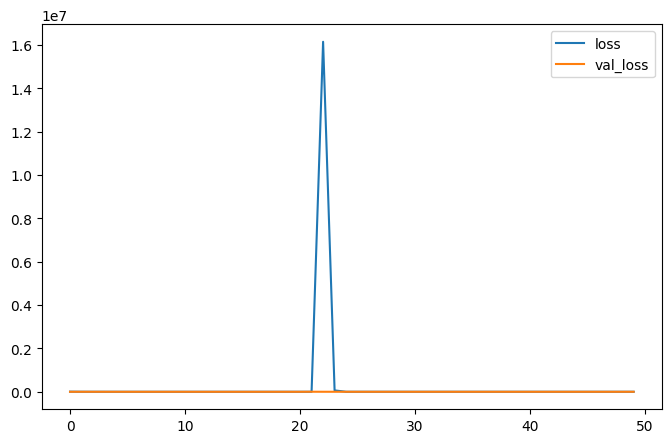

In [75]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [73]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
pred_y = model.predict(test_X)

285/285 [==============================] - 3s 8ms/step


In [74]:
from sklearn.metrics import r2_score, mean_squared_error

# Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
r2 = r2_score(test_y, pred_y)
rmse = np.sqrt(mean_squared_error(test_y, pred_y))


print("R2 score:", r2)
print("RMSE: ", rmse)

R2 score: 0.7189686860114571
RMSE:  22.98478131989393


CNN LSTM MODEL

In [76]:
train_X, train_y = split_sequence(train_data['sfu'], 27)
# print("train split done")
test_X, test_y = split_sequence(np.array(test_data['sfu']), 27)

In [77]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
train_X = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
test_X = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', train_X.shape)

Train set shape (17826, 1, 27, 1)


In [83]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, MaxPooling1D, Flatten, Conv1D, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer='adam')

optimizer = Adam(lr=0.001)
model_cnn_lstm.compile(optimizer=optimizer, loss='mse')
# Define checkpoint callback
checkpoint = ModelCheckpoint('CNNLSTM50.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

history = model_cnn_lstm.fit(train_X, train_y, epochs=50, verbose=1, validation_data = (test_X, test_y), callbacks=[checkpoint])

Epoch 1/50
558/558 [==============================] - 5s 6ms/step - loss: 487.2914 - val_loss: 199.7863
Epoch 2/50
558/558 [==============================] - 3s 5ms/step - loss: 157.0451 - val_loss: 164.0298
Epoch 3/50
558/558 [==============================] - 3s 5ms/step - loss: 123.7813 - val_loss: 169.7198
Epoch 4/50
558/558 [==============================] - 2s 4ms/step - loss: 114.9194 - val_loss: 171.2453
Epoch 5/50
558/558 [==============================] - 2s 4ms/step - loss: 110.6642 - val_loss: 178.3033
Epoch 6/50
558/558 [==============================] - 2s 4ms/step - loss: 105.5520 - val_loss: 179.7160
Epoch 7/50
558/558 [==============================] - 2s 4ms/step - loss: 108.0467 - val_loss: 176.8785
Epoch 8/50
558/558 [==============================] - 3s 5ms/step - loss: 103.4055 - val_loss: 183.7424
Epoch 9/50
558/558 [==============================] - 2s 4ms/step - loss: 101.6039 - val_loss: 242.0047
Epoch 10/50
558/558 [==============================] - 3s 5ms/st

In [86]:
test_X = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))

In [89]:
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features)) this is already done above
pred_y = model_cnn_lstm.predict(test_X)

285/285 [==============================] - 1s 2ms/step


In [90]:
from sklearn.metrics import r2_score, mean_squared_error

# Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
r2 = r2_score(test_y, pred_y)
rmse = np.sqrt(mean_squared_error(test_y, pred_y))


print("R2 score:", r2)
print("RMSE: ", rmse)

R2 score: 0.8876662352494111
RMSE:  14.531758647404613


2 cnn lstm

In [1]:
train_X, train_y = split_sequence(train_data['sfu'], 27)
# print("train split done")
test_X, test_y = split_sequence(np.array(test_data['sfu']), 27)

NameError: name 'split_sequence' is not defined

In [92]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
train_X = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
test_X = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', train_X.shape)

Train set shape (17826, 1, 27, 1)


In [106]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, MaxPooling1D, Flatten, Conv1D, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=4,  activation='relu'), input_shape=(None, n_steps, n_features)))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=32, kernel_size=4, activation='relu')))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer='adam')

optimizer = Adam(lr=0.001)
model_cnn_lstm.compile(optimizer=optimizer, loss='mse')
# Define checkpoint callback
checkpoint = ModelCheckpoint('CNNLSTM50.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

history = model_cnn_lstm.fit(train_X, train_y, epochs=50, verbose=1, validation_data = (test_X, test_y), callbacks=[checkpoint])

Epoch 1/50


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


558/558 [==============================] - 4s 5ms/step - loss: 913.4976 - val_loss: 347.9606
Epoch 2/50
558/558 [==============================] - 2s 4ms/step - loss: 324.7936 - val_loss: 247.4067
Epoch 3/50
558/558 [==============================] - 2s 4ms/step - loss: 250.7277 - val_loss: 240.4401
Epoch 4/50
558/558 [==============================] - 2s 4ms/step - loss: 215.2297 - val_loss: 239.6161
Epoch 5/50
558/558 [==============================] - 2s 4ms/step - loss: 206.4836 - val_loss: 222.4698
Epoch 6/50
558/558 [==============================] - 2s 4ms/step - loss: 208.6369 - val_loss: 247.5169
Epoch 7/50
558/558 [==============================] - 2s 4ms/step - loss: 199.2776 - val_loss: 367.9029
Epoch 8/50
558/558 [==============================] - 2s 4ms/step - loss: 198.8256 - val_loss: 245.8838
Epoch 9/50
558/558 [==============================] - 2s 4ms/step - loss: 182.8514 - val_loss: 250.3825
Epoch 10/50
558/558 [==============================] - 2s 4ms/step - loss: 

In [107]:
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features)) this is already done above
pred_y = model_cnn_lstm.predict(test_X)

285/285 [==============================] - 1s 2ms/step


In [108]:
from sklearn.metrics import r2_score, mean_squared_error

# Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
r2 = r2_score(test_y, pred_y)
rmse = np.sqrt(mean_squared_error(test_y, pred_y))


print("R2 score:", r2)
print("RMSE: ", rmse)

R2 score: 0.8653090218222668
RMSE:  15.912274885888893


2CNN2LSTM model 

In [6]:
train_X, train_y = split_sequence(train_data['sfu'], 27)
# print("train split done")
test_X, test_y = split_sequence(np.array(test_data['sfu']), 27)

NameError: name 'split_sequence' is not defined

In [116]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, MaxPooling1D, Flatten, Conv1D, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=16, kernel_size=14,  activation='relu'), input_shape=(None, n_steps, n_features)))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=32, kernel_size=4, activation='relu')))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(64, activation='relu', return_sequences= True))
model_cnn_lstm.add(LSTM(32, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer='adam')

optimizer = Adam(lr=0.001)
model_cnn_lstm.compile(optimizer=optimizer, loss='mse')
# Define checkpoint callback
checkpoint = ModelCheckpoint('CNNLSTM6432.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

history = model_cnn_lstm.fit(train_X, train_y, epochs=50, verbose=1, validation_data = (test_X, test_y), callbacks=[checkpoint])

Epoch 1/50


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


558/558 [==============================] - 5s 4ms/step - loss: 1006.8510 - val_loss: 188.0398
Epoch 2/50
558/558 [==============================] - 2s 4ms/step - loss: 140.0676 - val_loss: 168.9059
Epoch 3/50
558/558 [==============================] - 2s 4ms/step - loss: 102.4285 - val_loss: 138.0965
Epoch 4/50
558/558 [==============================] - 2s 4ms/step - loss: 85.6422 - val_loss: 142.0436
Epoch 5/50
558/558 [==============================] - 2s 4ms/step - loss: 80.8391 - val_loss: 145.2811
Epoch 6/50
558/558 [==============================] - 2s 4ms/step - loss: 68.6636 - val_loss: 130.9130
Epoch 7/50
558/558 [==============================] - 2s 4ms/step - loss: 66.2465 - val_loss: 136.9543
Epoch 8/50
558/558 [==============================] - 2s 4ms/step - loss: 62.9630 - val_loss: 134.9906
Epoch 9/50
558/558 [==============================] - 2s 4ms/step - loss: 59.6860 - val_loss: 135.2012
Epoch 10/50
558/558 [==============================] - 2s 4ms/step - loss: 56.89

In [117]:
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features)) this is already done above
pred_y = model_cnn_lstm.predict(test_X)

285/285 [==============================] - 1s 1ms/step


In [118]:
from sklearn.metrics import r2_score, mean_squared_error

# Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
r2 = r2_score(test_y, pred_y)
rmse = np.sqrt(mean_squared_error(test_y, pred_y))


print("R2 score:", r2)
print("RMSE: ", rmse)

R2 score: 0.9246940528516168
RMSE:  11.898101151860521


In [134]:
train_X, train_y = split_sequence(np.array(train_data['sfu']), 27)
# print("train split done")
test_X, test_y = split_sequence(np.array(test_data['sfu']), 27)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [136]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# Define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# Compile model with learning rate of 0.001
optimzer = Adam(lr = 0.001)
# optimizer = SGD(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Define checkpoint callback
checkpoint = ModelCheckpoint('model_weightsSGD.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Fit model with checkpointing
history = model.fit(X, y, epochs=50, verbose=1, validation_data = (test_X, test_y), callbacks=[checkpoint])

Epoch 1/50


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


843/843 [==============================] - 10s 11ms/step - loss: nan - val_loss: nan
Epoch 2/50
843/843 [==============================] - 10s 11ms/step - loss: nan - val_loss: nan
Epoch 3/50
841/843 [============================>.] - ETA: 0s - loss: nan

KeyboardInterrupt: 

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
pred_y = model.predict(test_X)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
r2 = r2_score(test_y, pred_y)
rmse = np.sqrt(mean_squared_error(test_y, pred_y))


print("R2 score:", r2)
print("RMSE: ", rmse)

In [208]:
train_X, train_y = split_sequence(np.array(train_data['sfu']), 27)
# print("train split done")
test_X, test_y = split_sequence(np.array(test_data['sfu']), 27)

3 layer with dropout and leaky relu

In [201]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, LeakyReLU, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

n_features = 1
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))

# Define model
model = Sequential()
model.add(LSTM(128,return_sequences= True,  input_shape=(n_steps, n_features)))
model.add(LeakyReLU(alpha = 0.5))
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU(alpha = 0.5))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model with learning rate of 0.001
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Define checkpoint callback
checkpoint = ModelCheckpoint('3LayerLSTM643216.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Fit model with checkpointing
history = model.fit(train_X, train_y, epochs=50, verbose=1, validation_data = (test_X, test_y), callbacks=[checkpoint])

Epoch 1/50
558/558 [==============================] - 56s 90ms/step - loss: 14311.6025 - val_loss: 6005.9253
Epoch 2/50
558/558 [==============================] - 52s 93ms/step - loss: 8604.9766 - val_loss: 3163.3945
Epoch 3/50
558/558 [==============================] - 52s 94ms/step - loss: 5526.4844 - val_loss: 2057.0815
Epoch 4/50
558/558 [==============================] - 51s 91ms/step - loss: 4035.6338 - val_loss: 1889.8063
Epoch 5/50
558/558 [==============================] - 50s 89ms/step - loss: 3468.4131 - val_loss: 2069.3254
Epoch 6/50
558/558 [==============================] - 48s 87ms/step - loss: 3295.4119 - val_loss: 2266.9373
Epoch 7/50
558/558 [==============================] - 48s 86ms/step - loss: 3253.5493 - val_loss: 2354.8044
Epoch 8/50
558/558 [==============================] - 45s 82ms/step - loss: 2863.6934 - val_loss: 569.0808
Epoch 9/50
558/558 [==============================] - 47s 85ms/step - loss: 1284.1479 - val_loss: 286.5464
Epoch 10/50
558/558 [========

In [202]:
model.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 27, 128)           66560     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 27, 128)           0         
                                                                 
 lstm_51 (LSTM)              (None, 27, 128)           131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 27, 128)           0         
                                                                 
 dropout_3 (Dropout)         (None, 27, 128)           0         
                                                                 
 lstm_52 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_4 (Dropout)         (None, 64)              

In [ ]:
from keras.callbacks import EarlyStopping
early_Stopping =EarlyStopping(monitor = 'val_loss'
                              patience = 5, 
                              mode = 'min')

In [203]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
pred_y = model.predict(test_X)

285/285 [==============================] - 10s 28ms/step


In [204]:
from sklearn.metrics import r2_score, mean_squared_error

# Assuming you have your true values in 'y_true' and predicted values in 'y_pred'
r2 = r2_score(test_y, pred_y)
rmse = np.sqrt(mean_squared_error(test_y, pred_y))


print("R2 score:", r2)
print("RMSE: ", rmse)

R2 score: 0.964241858872422
RMSE:  8.19880365836983


In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
pred_y = model.predict(test_X)

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
pred_y = model.predict(test_X)

In [209]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
train_X = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
test_X = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', train_X.shape)

Train set shape (17826, 1, 27, 1)


In [212]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, MaxPooling1D, Flatten, Conv1D, TimeDistributed, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=14, activation='relu'), input_shape=(None, n_steps, n_features)))
# model_cnn_lstm.add(LeakyReLU(alpha =0.5))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=32, kernel_size=4, activation='relu')))
# model_cnn_lstm.add(LeakyReLU(alpha =0.5))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(128, return_sequences= True))
model_cnn_lstm.add(LeakyReLU(alpha =0.5))
model_cnn_lstm.add(LSTM(128, return_sequences= True))
model_cnn_lstm.add(LeakyReLU(alpha =0.5))
model_cnn_lstm.add(Dropout(0.3))
model_cnn_lstm.add(LSTM(64, activation='relu', return_sequences= True))
model_cnn_lstm.add(Dropout(0.3))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer='adam')

optimizer = Adam(lr=0.001)
model_cnn_lstm.compile(optimizer=optimizer, loss='mse')
# Define checkpoint callback
checkpoint = ModelCheckpoint('CNNLSTM6432.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

history = model_cnn_lstm.fit(train_X, train_y, epochs=50, verbose=1, validation_data = (test_X, test_y), callbacks=[checkpoint])

Epoch 1/50
558/558 [==============================] - 10s 10ms/step - loss: 5388.0488 - val_loss: 2426.9719
Epoch 2/50
558/558 [==============================] - 5s 8ms/step - loss: 3415.8975 - val_loss: 2189.0471
Epoch 3/50
558/558 [==============================] - 5s 9ms/step - loss: 3419.0452 - val_loss: 2394.7275
Epoch 4/50
558/558 [==============================] - 5s 9ms/step - loss: 3410.2253 - val_loss: 2539.8289
Epoch 5/50
558/558 [==============================] - 5s 8ms/step - loss: 3407.8948 - val_loss: 2287.3403
Epoch 6/50
558/558 [==============================] - 5s 8ms/step - loss: 3411.4451 - val_loss: 2452.6375
Epoch 7/50
558/558 [==============================] - 5s 8ms/step - loss: 3408.1262 - val_loss: 2557.9590
Epoch 8/50
558/558 [==============================] - 5s 9ms/step - loss: 3410.2280 - val_loss: 2449.3931
Epoch 9/50
558/558 [==============================] - 5s 9ms/step - loss: 3410.9556 - val_loss: 2292.1445
Epoch 10/50
258/558 [============>..........

KeyboardInterrupt: 